In [1]:
import os
import pandas as pd

Training image paths and labels

In [2]:
#csv files path
path = './data'
image_paths_csv = "data_image_paths.csv"

In [3]:
image_paths = pd.read_csv(os.path.join(path,image_paths_csv),dtype=str,header=None)
image_paths.columns = ['image_path']
image_paths.head()

,image_path
0,data/images/patient06359/study1_positive/image...
1,data/images/patient06359/study1_positive/image...
2,data/images/patient06360/study1_positive/image...
3,data/images/patient06360/study1_positive/image...
4,data/images/patient06360/study1_positive/image...


In [4]:
image_paths['label'] = image_paths['image_path'].map(lambda x:1 if 'positive' in x else 0)
image_paths['patient_id']  = image_paths['image_path'].apply(lambda x: x.split('/')[2].replace('patient',''))
image_paths.head()

,image_path,label,patient_id
0,data/images/patient06359/study1_positive/image...,1,06359
1,data/images/patient06359/study1_positive/image...,1,06359
2,data/images/patient06360/study1_positive/image...,1,06360
3,data/images/patient06360/study1_positive/image...,1,06360
4,data/images/patient06360/study1_positive/image...,1,06360


In [5]:
print(image_paths['image_path'].size)

10411


https://www.kaggle.com/code/pratinavseth/mura-classification-ensemble

In [6]:
image_paths.columns

Index(['image_path', 'label', 'patient_id'], dtype='object')

Text(0.5, 1.0, 'Negative Test')

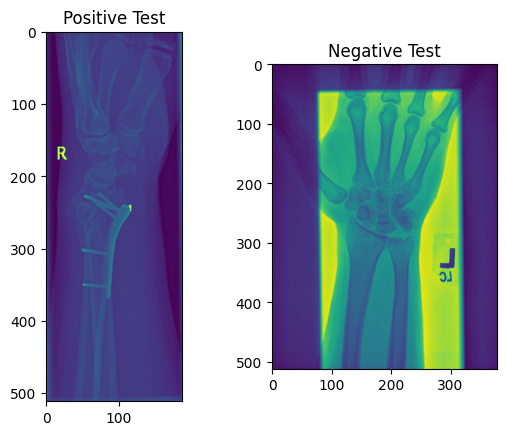

In [7]:
import matplotlib.pyplot as plt

img1 = plt.imread(image_paths['image_path'][0])
img2 = plt.imread(image_paths['image_path'][147])


figure = plt.figure()
figure.add_subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Positive Test")

figure.add_subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Negative Test")

In [8]:
print(image_paths['image_path'].size)

10411


In [9]:
# shuffling the data frame
# https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

image_paths = image_paths.sample(frac=1).reset_index(drop=True)

In [10]:
train_data = image_paths[0:8327]
image_paths = image_paths[8327:]

valid_data = image_paths[0:1042]
image_paths = image_paths[1042:]

test_data = image_paths[0:1042]
image_paths = image_paths[1042:]

In [11]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

8327
1042
1042


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=(1./255),
    samplewise_center = True,
    samplewise_std_normalization = True,
    rotation_range = 5, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1,
    zoom_range = 0.1, 
    horizontal_flip = True,
    vertical_flip = True
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data, 
    x_col='image_path', 
    y_col='label',
    target_size=(128, 128), 
    batch_size=64,
    label_mode='int', 
    shuffle=True, 
    class_mode='other',
    color_mode = 'rgb')



valid_datagen = ImageDataGenerator(rescale=(1./255),
    samplewise_center = True,
    samplewise_std_normalization = True,
    rotation_range = 0, 
    width_shift_range = 0., 
    height_shift_range = 0.,
    zoom_range = 0.0, 
    horizontal_flip = False,
    vertical_flip = False
    )

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_data, 
    x_col='image_path', 
    y_col='label',
    target_size=(128, 128), 
    batch_size=64,
    label_mode='int', 
    shuffle=True, 
    class_mode='other',
    color_mode = 'rgb'   
)


Found 8327 validated image filenames.
Found 1042 validated image filenames.


In [13]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 128, 128, 3)
labels batch shape: (64,)


In [48]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

model.add(layers.Dropout(0.05))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
            optimizer='adam', # learning rate
            metrics=['acc'])


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 128)     

In [51]:
history = model.fit(
    train_generator,
    steps_per_epoch=130, # 8327 (number of images) / 64 (batch size) = 130
    epochs=30,
    validation_data=valid_generator,
    validation_steps=16 # 1042 (number of images) / 64 (batch size) = 16
)

Epoch 1/30
130/130 [==============================] - 34s 261ms/step - loss: 0.6495 - acc: 0.6285 - val_loss: 0.5963 - val_acc: 0.6826
Epoch 2/30
130/130 [==============================] - 34s 259ms/step - loss: 0.5994 - acc: 0.6753 - val_loss: 0.5462 - val_acc: 0.7158
Epoch 3/30
130/130 [==============================] - 34s 260ms/step - loss: 0.5736 - acc: 0.7053 - val_loss: 0.5273 - val_acc: 0.7471
Epoch 4/30
130/130 [==============================] - 35s 265ms/step - loss: 0.5341 - acc: 0.7373 - val_loss: 0.5727 - val_acc: 0.7080
Epoch 5/30
130/130 [==============================] - 34s 262ms/step - loss: 0.5234 - acc: 0.7443 - val_loss: 0.4886 - val_acc: 0.7559
Epoch 6/30
130/130 [==============================] - 34s 262ms/step - loss: 0.5000 - acc: 0.7606 - val_loss: 0.5100 - val_acc: 0.7520
Epoch 7/30
130/130 [==============================] - 34s 263ms/step - loss: 0.4941 - acc: 0.7692 - val_loss: 0.4823 - val_acc: 0.7764
Epoch 8/30
130/130 [==============================] - 3

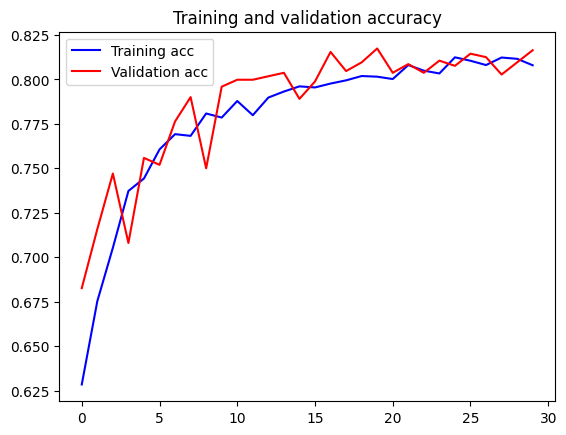

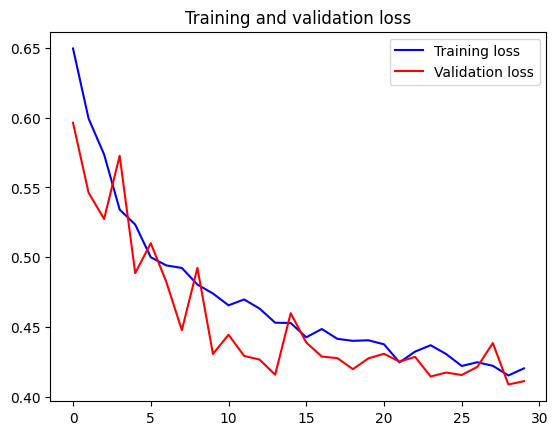

In [52]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
test_datagen = ImageDataGenerator(rescale=1./255,
    samplewise_center = True,
    samplewise_std_normalization = True,
    rotation_range = 0, 
    width_shift_range = 0., 
    height_shift_range = 0.,
    zoom_range = 0.0, 
    horizontal_flip = False,
    vertical_flip = False)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data, 
    x_col='image_path', 
    y_col='label',
    target_size=(128, 128), 
    batch_size=260,
    label_mode='int', 
    class_mode='other',
    color_mode = 'rgb',
    shuffle=False    
)

Found 1042 validated image filenames.


In [61]:
model.evaluate(test_generator, steps=4)

4/4 [==============================] - 2s 509ms/step - loss: 0.4328 - acc: 0.8096


[0.43276247382164, 0.8096153736114502]

In [66]:
model.save("MURA_model.h5")

In [67]:
from keras.models import load_model

loaded_model = load_model('MURA_model.h5')

In [69]:
loaded_model.evaluate(test_generator, steps=4)

4/4 [==============================] - 2s 505ms/step - loss: 0.4328 - acc: 0.8096


[0.43276247382164, 0.8096153736114502]